# Importações

In [70]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from scipy.signal import convolve2d
from skimage.feature import hog
from skimage.draw import line_aa 

# Carregar imagem

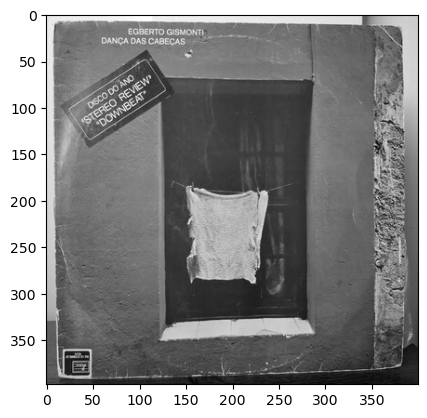

In [71]:
original_img = Image.open('images/danca_das_cabecas.jpg')

gray_img = original_img.convert('L')

gray_img = np.asarray(gray_img).astype(np.uint8)

plt.imshow(gray_img, cmap='gray')
plt.show()

# HOG

## Nossa implementação

### Gradientes

In [72]:
def compute_gradients(img):
    kernel_x = np.array([-1, 0, 1]).reshape(1, 3)
    kernel_y = kernel_x.T

    gx = convolve2d(img, kernel_x, mode='same', boundary='symm')
    gy = convolve2d(img, kernel_y, mode='same', boundary='symm')
    
    return gx, gy

In [73]:
gx, gy = compute_gradients(gray_img)

### Magnitude e direção

In [74]:
magnitude = np.sqrt(gx ** 2 + gy ** 2)

direction = np.arctan2(gy, gx)

direction_deg = np.rad2deg(direction) % 180

### Cálculo do histograma

In [75]:
H, W = gray_img.shape

cell_size = 8

n_cells_y = H // cell_size
n_cells_x = W // cell_size

n_bins = 9

hog_cells = np.zeros((n_cells_y, n_cells_x, n_bins))

for i in range(n_cells_y):
    for j in range(n_cells_x):

        y_start = i * cell_size
        x_start = j * cell_size

        cell_magnitude = magnitude[y_start : y_start+cell_size, x_start : x_start+cell_size]
        cell_direction_deg = direction_deg[y_start : y_start+cell_size, x_start : x_start+cell_size]
        
        hist, _ = np.histogram(cell_direction_deg, bins=n_bins, range=(0, 180), weights=cell_magnitude)
        hog_cells[i, j] = hist

### Normalização

In [76]:
epsilon = 1e-5
hog_features = []

for i in range(n_cells_y - 1):
    for j in range(n_cells_x - 1):

        block = hog_cells[i : i+2, j : j+2]
        
        block_vector = block.flatten()
        
        block_norm = block_vector / np.sqrt(np.sum(block_vector**2) + epsilon)
        
        hog_features.append(block_norm)

### Descritor final

In [77]:
hog_descriptor = np.array(hog_features).flatten()

print(f"Dimensão da Imagem: {gray_img.shape}")
print(f"Grade de Células: {hog_cells.shape}")
print(f"Número de Blocos: {len(hog_features)}")

print(f"Tamanho do Vetor HOG Final: {hog_descriptor.shape}")


Dimensão da Imagem: (398, 400)
Grade de Células: (49, 50, 9)
Número de Blocos: 2352
Tamanho do Vetor HOG Final: (84672,)


### Visualização parcial

In [78]:
def show_image(original_img, hog_img, legend):
    plt.figure(figsize=(10, 5))
    
    plt.subplot(121), plt.imshow(original_img, cmap='gray'), plt.title(legend[0])
    plt.subplot(122), plt.imshow(hog_img, cmap='gray'), plt.title(legend[1])
    
    plt.show()

def view_hog_cells(hog_cells, cell_size, img_shape):

    H, W = img_shape
    n_cells_y, n_cells_x, n_bins = hog_cells.shape
    
    viz_image = np.zeros((H, W), dtype=float)
    
    angles = np.linspace(0, np.pi, n_bins, endpoint=False)
    
    radius = int(cell_size / 2)
    
    for i in range(n_cells_y):
        for j in range(n_cells_x):
            
            cx = j * cell_size + cell_size // 2
            cy = i * cell_size + cell_size // 2
            
            for b in range(n_bins):
                angle = angles[b]
                strength = hog_cells[i, j, b]
                
                if strength < 1e-6: continue 
                
                dx = radius * np.cos(angle)
                dy = radius * np.sin(angle)
                
                r0 = int(round(cy - dy))
                c0 = int(round(cx - dx))
                r1 = int(round(cy + dy))
                c1 = int(round(cx + dx))
                
                rr, cc, val = line_aa(r0, c0, r1, c1)
                
                valid = (rr >= 0) & (rr < H) & (cc >= 0) & (cc < W)
                
                viz_image[rr[valid], cc[valid]] += val[valid] * strength

    max_val = viz_image.max()
    if max_val > 0:
        viz_image /= max_val
        
    return viz_image

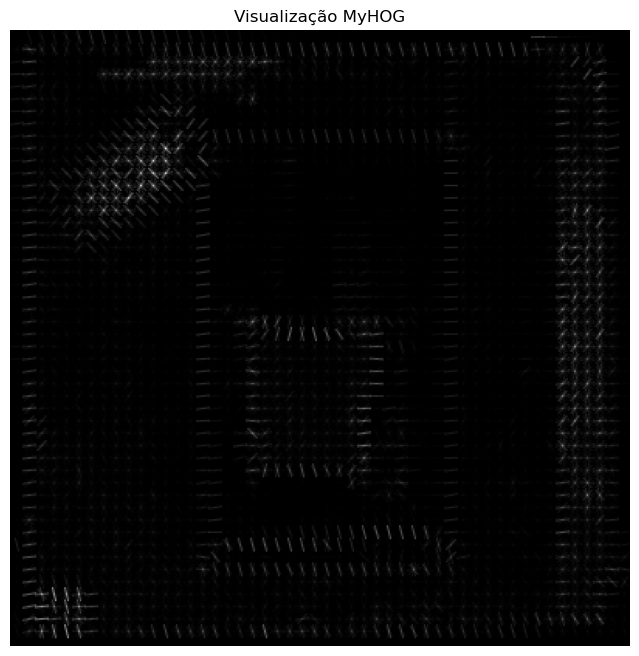

In [79]:
my_hog_view = view_hog_cells(hog_cells, 8, gray_img.shape)

plt.figure(figsize=(8, 8))
plt.imshow(my_hog_view, cmap='gray')
plt.title("Visualização MyHOG")
plt.axis('off')
plt.show()

## Aplicação via skimage 

Tamanho do Vetor HOG Final: (84672,)


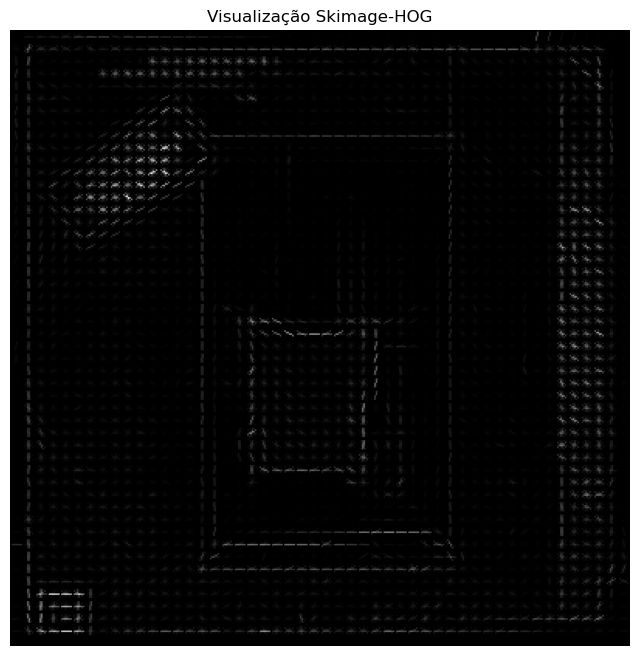

In [80]:
fd, hog_image = hog(gray_img, 
                    orientations=9, 
                    pixels_per_cell=(8, 8), 
                    block_norm='L2',  
                    cells_per_block=(2, 2), 
                    visualize=True,
                    feature_vector=True)

print(f"Tamanho do Vetor HOG Final: {fd.shape}")

plt.figure(figsize=(8, 8))
plt.imshow(hog_image, cmap='gray')
plt.title("Visualização Skimage-HOG")
plt.axis('off')
plt.show()

# show_image(gray_img, hog_image, legend=['Imagem original', 'Magnitude e direção dos gradientes'])

Tamanho Vetor Skimage: (84672,)
Tamanho Vetor Manual:  (84672,)

Distância Euclidiana (Erro): 0.2887
Correlação (Similaridade):   1.0000
(Correlação 1.0 significa vetores idênticos em forma)


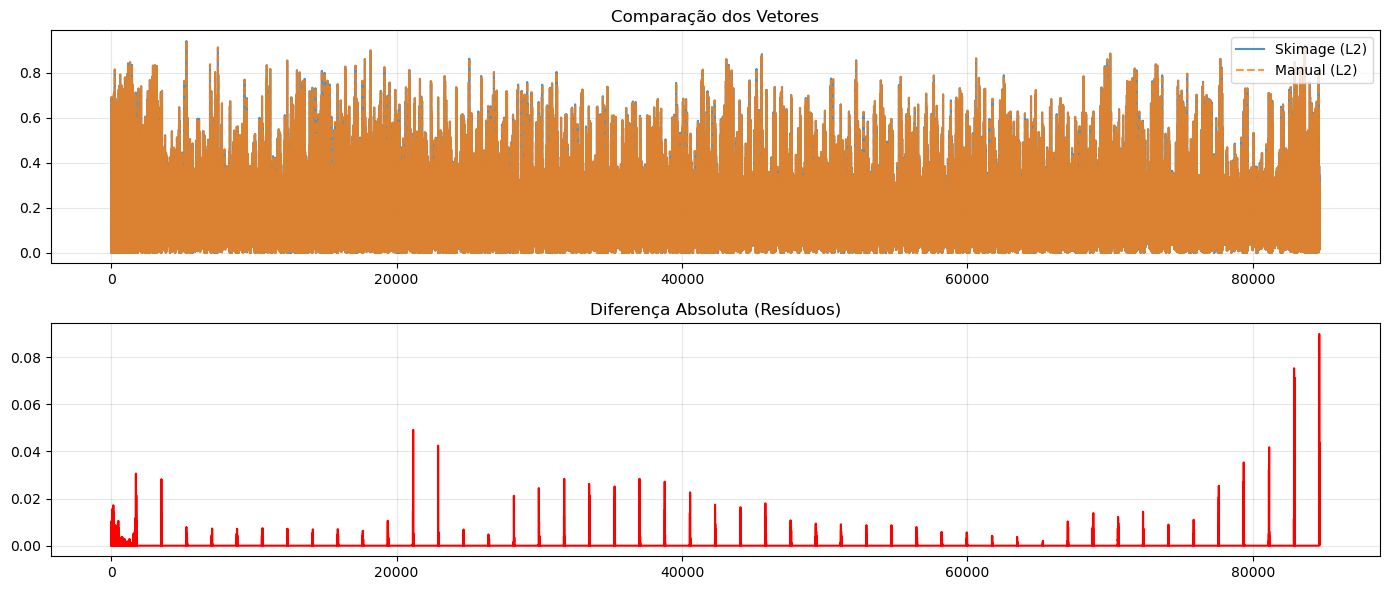

In [81]:
print(f"Tamanho Vetor Skimage: {fd.shape}")
print(f"Tamanho Vetor Manual:  {hog_descriptor.shape}")

# Cálculo do Erro (Distância Euclidiana e Correlação)
erro = np.linalg.norm(fd - hog_descriptor)
correlacao = np.corrcoef(fd, hog_descriptor)[0, 1]

print(f"\nDistância Euclidiana (Erro): {erro:.4f}")
print(f"Correlação (Similaridade):   {correlacao:.4f}")
print("(Correlação 1.0 significa vetores idênticos em forma)")

# Plotagem dos Gráficos
plt.figure(figsize=(14, 6))

# Plot 1: Sobreposição dos vetores (Zoom em uma parte)
plt.subplot(2, 1, 1)
plt.plot(fd, label='Skimage (L2)', alpha=0.8)
plt.plot(hog_descriptor, label='Manual (L2)', alpha=0.8, linestyle='--')
plt.title('Comparação dos Vetores')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 2: Diferença Absoluta
plt.subplot(2, 1, 2)
plt.plot(np.abs(fd - hog_descriptor), color='red')
plt.title('Diferença Absoluta (Resíduos)')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Visualização geral do algoritmo HOG


## Divisão em regiões (grid)

In [82]:
def grid_view(img, cell_size, line_color=(0, 255, 0), line_thickness=1):

    W, H = img.shape[:2]

    n_horizontal_cells = H // cell_size
    n_vertical_cells = W // cell_size
    
    H_crop = n_horizontal_cells * cell_size
    W_crop = n_vertical_cells * cell_size
    
    cropped_img = img[0:W_crop, 0:H_crop]
    img_view = cropped_img.copy()
    
    for i in range(0, n_horizontal_cells + 1):
        x = i * cell_size
        
        if x == H_crop:
            x = x - 1
            
        cv2.line(img_view, (x, 0), (x, W_crop), line_color, line_thickness )

    for j in range(0, n_vertical_cells + 1):
        y = j * cell_size
        
        if y == W_crop:
            y = y - 1
            
        cv2.line(img_view, (0, y), (H_crop, y), line_color, line_thickness )

    print(f"Dimensões processadas: {H_crop}x{W_crop}")
    print(f"Grid desenhado com {n_vertical_cells}x{n_horizontal_cells} células.")

    return img_view

Dimensões processadas: 400x392
Grid desenhado com 49x50 células.


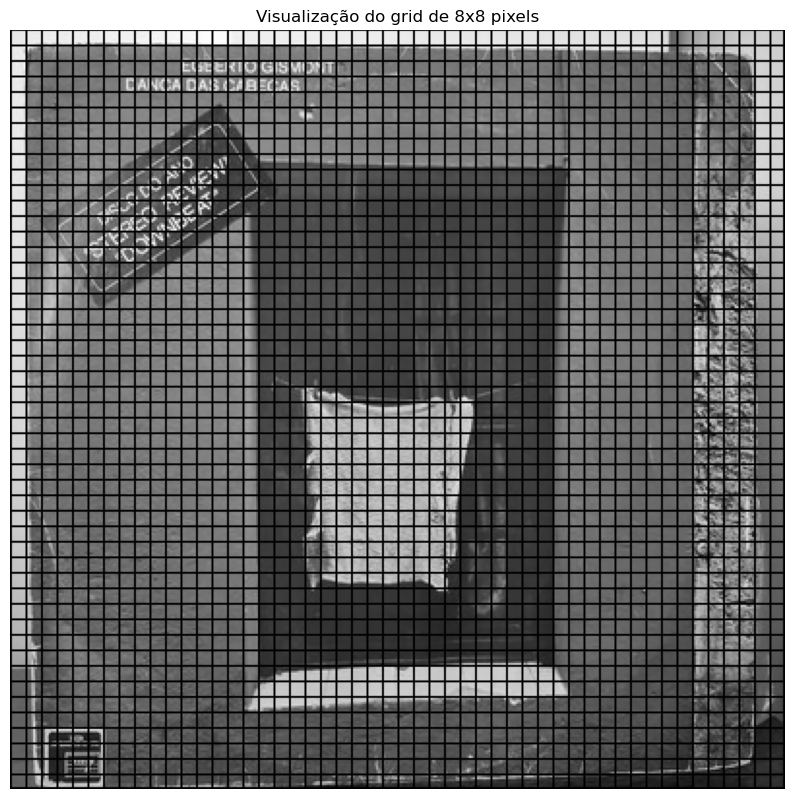

In [83]:
img_grid = grid_view(gray_img, cell_size, line_color, line_thickness)

img_rgb = cv2.cvtColor(img_grid, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(10, 10))
plt.imshow(img_rgb)
plt.title(f"Visualização do grid de {cell_size}x{cell_size} pixels")
plt.axis('off')
plt.show()

## Magnitude e direção dos gradientes


In [84]:
def get_cell(img, gx, gy, top, left, block_h, block_w):
    
    cell_img = img[top:top+block_h, left:left+block_w]
    cell_gx  = gx[top:top+block_h, left:left+block_w]
    cell_gy  = gy[top:top+block_h, left:left+block_w]
    
    return cell_img, cell_gx, cell_gy

def plot_cell_gradients(cell_img, cell_gx, cell_gy, subsample=1):

    H, W = cell_img.shape
    
    Y, X = np.mgrid[0:H:subsample, 0:W:subsample]

    U = cell_gx[::subsample, ::subsample]
    V = cell_gy[::subsample, ::subsample] 

    magnitude = np.sqrt(U**2 + V**2)
  
    max_mag = np.max(magnitude)
    if max_mag == 0: max_mag = 1 
    
    plt.figure(figsize=(6,6))
    plt.imshow(cell_img, cmap="gray")
    
    plt.quiver(X, Y, U, V, 
               color="red", 
               angles="xy", 
               scale_units="xy", 
               scale=max_mag, 
               width=0.005,
               headwidth=4)
    
    plt.title("Campo vetorial dos gradientes (pixel por pixel)")
    plt.axis("off")
    plt.show()

def plot_mean_cell_gradients(cell_img, cell_gx, cell_gy):

    H, W = cell_img.shape
    
    magnitude = np.sqrt(cell_gx**2 + cell_gy**2)
    avg_mag = np.mean(magnitude)
   
    mean_gx = np.mean(cell_gx)
    mean_gy = np.mean(cell_gy)
    
    avg_ang = np.arctan2(mean_gy, mean_gx)

    center_x, center_y = W // 2, H // 2
    
    scale_factor = 0.05 
    
    dx = (avg_mag * scale_factor) * np.cos(avg_ang)
    dy = (avg_mag * scale_factor) * np.sin(avg_ang)

    plt.figure(figsize=(4, 4))
    plt.imshow(cell_img, cmap='gray')
    
    if avg_mag > 1.0: 
        plt.arrow(center_x, center_y, dx, dy, 
                  color='red', 
                  width=W*0.02,        
                  head_width=W*0.15, 
                  length_includes_head=True) 

    plt.title(f"Direção média dos gradientes da célula")
    plt.axis('off')
    plt.show()
    
def plot_gradients_view(img_full, gx_full, gy_full, top, left, block_h, block_w, cell_size=8):
   
    if len(img_full.shape) == 2:
        img_vis = cv2.cvtColor(img_full, cv2.COLOR_GRAY2BGR)
    else:
        img_vis = img_full.copy()
    
    H, W = img_full.shape[:2]
    
    for y in range(0, H, cell_size):
        cv2.line(img_vis, (0, y), (W, y), (200, 200, 200), 1)
    for x in range(0, W, cell_size):
        cv2.line(img_vis, (x, 0), (x, H), (200, 200, 200), 1)
        
    cv2.rectangle(img_vis, (left, top), (left + block_w, top + block_h), (0, 0, 255), 2)
    
    # Grid com a célula selecionada destacada
    plt.figure(figsize=(8, 8))
    plt.imshow(cv2.cvtColor(img_vis, cv2.COLOR_BGR2RGB)) 
    plt.title(f"Seleção da célula (Top: {top}, Left: {left})")
    plt.axis('off')
    plt.show()

    b_img, b_gx, b_gy = get_cell(img_full, gx_full, gy_full, top, left, block_h, block_w)

    # Pixels da região selecionada
    plt.figure(figsize=(4, 4))
    plt.imshow(b_img, cmap="gray")
    plt.title("Pixels da célula selecionada")
    plt.axis('off')
    plt.show()

    # Visualização dos gradientes
    plot_cell_gradients(b_img, b_gx, b_gy, subsample=1)
    
    plot_mean_cell_gradients(b_img, b_gx, b_gy)

Dimensões: Altura=398, Largura=400
Célula Central (índices): [24, 25]
Coordenadas em Pixels (top, left): 192, 200


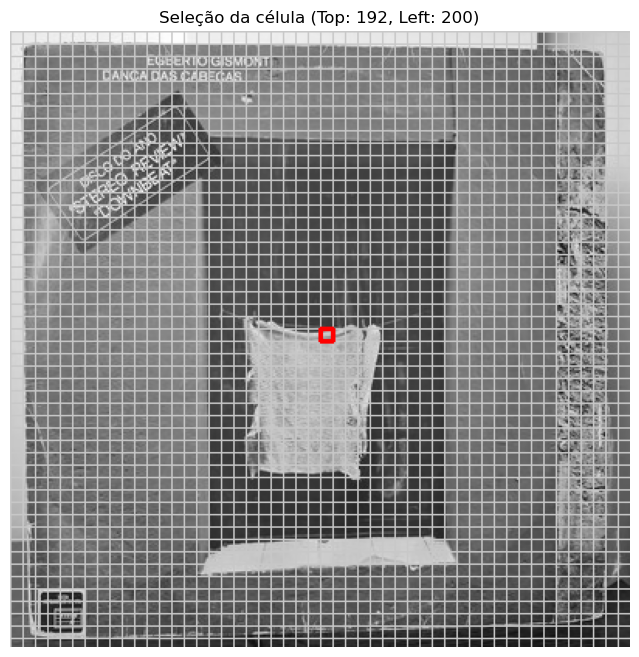

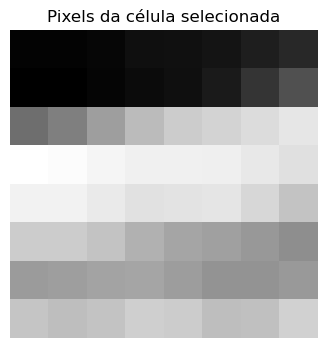

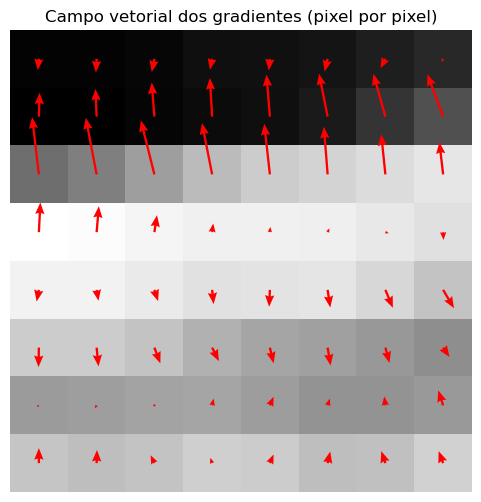

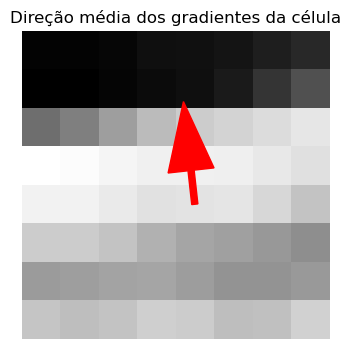

In [85]:
H, W = gray_img.shape 

print(f"Dimensões: Altura={H}, Largura={W}")

n_cells_y = H // cell_size
n_cells_x = W // cell_size

idx_center_y = n_cells_y // 2
idx_center_x = n_cells_x // 2

top = idx_center_y * cell_size
left = idx_center_x * cell_size

print(f"Célula Central (índices): [{idx_center_y}, {idx_center_x}]")
print(f"Coordenadas em Pixels (top, left): {top}, {left}")

gx, gy = compute_gradients(gray_img)
block_h, block_w = cell_size, cell_size

plot_gradients_view(gray_img, gx, gy, top, left, block_h, block_w, cell_size=8)

## Histograma

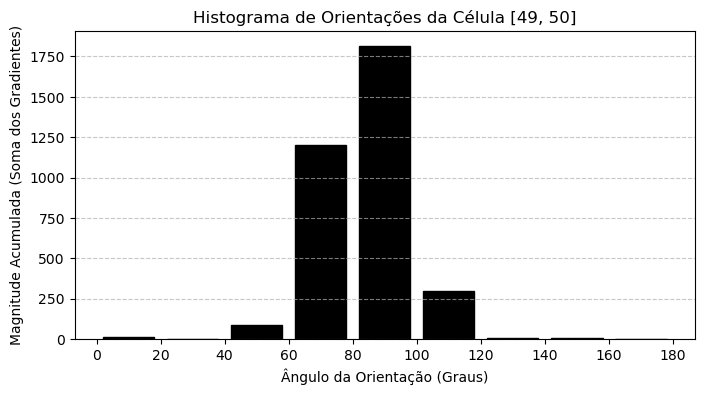

In [86]:
hist_da_celula = hog_cells[idx_center_y, idx_center_x]

n_bins = 9
bin_width = 180 / n_bins  

bin_centers = np.arange(0, 180, bin_width) + (bin_width / 2)

plt.figure(figsize=(8, 4))
plt.bar(bin_centers, hist_da_celula, width=bin_width * 0.8, color='black', edgecolor='black')

plt.xlabel('Ângulo da Orientação (Graus)')
plt.ylabel('Magnitude Acumulada (Soma dos Gradientes)')
plt.title(f'Histograma de Orientações da Célula [{n_cells_y}, {n_cells_x}]')
plt.xticks(np.arange(0, 181, 20)) 
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()